In [ ]:
!nvidia-smi

Sat Oct 18 02:49:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install numba cupy-cuda12x

# Exercise *1*

In [ ]:
import cupy as cp

# Crear un array en GPU
x = cp.arange(10**6, dtype=cp.float32)
y = cp.arange(10**6, dtype=cp.float32)

# Sumar en GPU
z = x + y

print("Suma GPU:", z[:5])
print("Tipo:", type(z))
print("Está en GPU:", z.device)

Suma GPU: [0. 2. 4. 6. 8.]
Tipo: <class 'cupy.ndarray'>
Está en GPU: <CUDA Device 0>


# Exercise 2

In [ ]:
import cupy as cp

kernel_code = r'''
extern "C" __global__
void add_arrays(const float* a, const float* b, float* c, int n) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
        c[i] = a[i] + b[i];
}
'''

add_kernel = cp.RawKernel(kernel_code, "add_arrays")

n = 1000000
a = cp.arange(n, dtype=cp.float32)
b = cp.arange(n, dtype=cp.float32)
c = cp.zeros_like(a)

threads = 256
blocks = (n + threads - 1) // threads

add_kernel((blocks,), (threads,), (a, b, c, n))
print(c[:10])

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


# Exercise 3

Saving pikachu.jpg to pikachu (1).jpg
Dimensiones: (600, 678, 3)


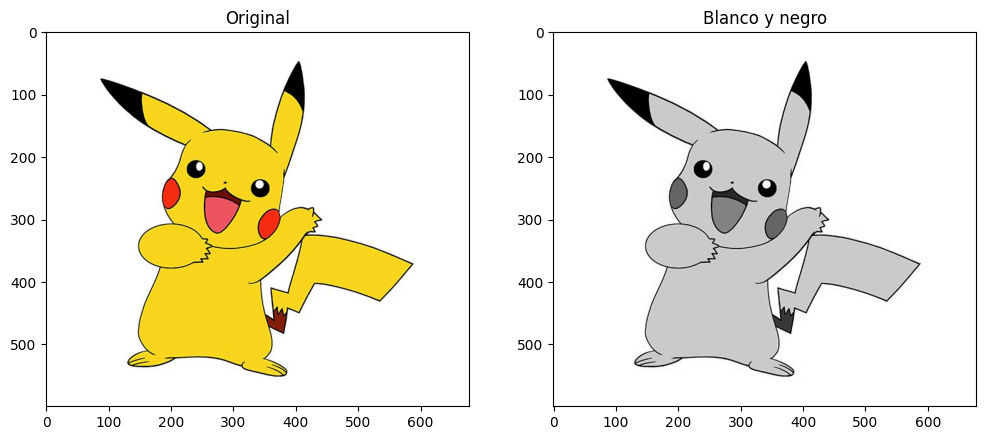

In [7]:
import cv2
import cupy as cp
from google.colab import files
import matplotlib.pyplot as plt

# Subir una imagen desde tu PC
uploaded = files.upload()

# Leer la imagen (usa el nombre del archivo que subas)
img_name = list(uploaded.keys())[0]
img = cv2.imread(img_name)

# Convertir BGR (formato de OpenCV) a RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("Dimensiones:", img.shape)

kernel_code = r'''
extern "C" __global__
void rgb_to_gray(const unsigned char* rgb, unsigned char* gray, int width, int height) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int size = width * height;

    if (i < size) {
        int idx = i * 3;  // cada pixel tiene 3 valores: R,G,B
        unsigned char r = rgb[idx];
        unsigned char g = rgb[idx + 1];
        unsigned char b = rgb[idx + 2];

        // Conversión a gris (usando ponderación perceptual)
        gray[i] = (unsigned char)(0.299f * r + 0.587f * g + 0.114f * b);
    }
}
'''

add_kernel = cp.RawKernel(kernel_code, "rgb_to_gray")

height, width, channels = img.shape

# Copiar imagen a GPU
img_gpu = cp.asarray(img, dtype=cp.uint8).ravel()  # convertir a 1D
gray_gpu = cp.zeros(width * height, dtype=cp.uint8)

threads = 256
blocks = (width * height + threads - 1) // threads

# Ejecutar kernel
add_kernel((blocks,), (threads,), (img_gpu, gray_gpu, width, height))

# Copiar resultado de vuelta a CPU
gray_img = cp.asnumpy(gray_gpu).reshape(height, width)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(gray_img, cmap='gray')
plt.title("Blanco y negro")

plt.show()